In [3]:
# @article{Hug2020,
#   doi = {10.21105/joss.02174},
#   url = {https://doi.org/10.21105/joss.02174},
#   year = {2020},
#   publisher = {The Open Journal},
#   volume = {5},
#   number = {52},
#   pages = {2174},
#   author = {Nicolas Hug},
#   title = {Surprise: A Python library for recommender systems},
#   journal = {Journal of Open Source Software}
# }


#create svd model with 80/20 train/test split
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

df = pd.read_csv('joined_dataset.csv', low_memory=False)

reader = Reader(rating_scale=(1, 10)) 
data = Dataset.load_from_df(df[['User-ID', 'ISBN', 'Book-Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()

model.fit(trainset)
predictions = model.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.6363
MAE:  1.2646


1.2646335055990605

In [4]:
#cross validate to ensure accuracy and consistency
from surprise.model_selection import cross_validate

cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6368  1.6377  1.6332  1.6341  1.6377  1.6359  0.0019  
MAE (testset)     1.2642  1.2607  1.2619  1.2626  1.2633  1.2626  0.0012  
Fit time          7.48    6.93    6.93    6.96    7.17    7.09    0.21    
Test time         0.55    0.87    0.44    0.47    0.92    0.65    0.20    


{'test_rmse': array([1.6368409 , 1.63771537, 1.63323961, 1.63405845, 1.63769497]),
 'test_mae': array([1.26422377, 1.26072314, 1.26189087, 1.26262538, 1.26331162]),
 'fit_time': (7.475309133529663,
  6.925405025482178,
  6.929671049118042,
  6.956211805343628,
  7.168354272842407),
 'test_time': (0.5482470989227295,
  0.8688504695892334,
  0.4442899227142334,
  0.4731173515319824,
  0.9177079200744629)}

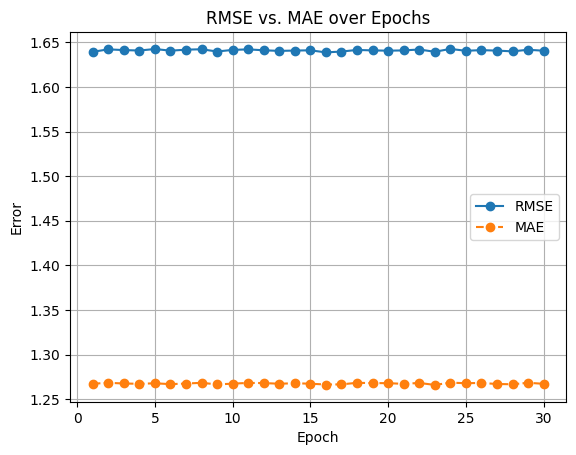

In [6]:
import matplotlib.pyplot as plt

#create new train and test set and build new model
trainset, testset = train_test_split(data, test_size=0.2)
n_epochs = 30
model = SVD(n_epochs=n_epochs)

rmse_epoch = []
mae_epoch = []

#track rmse and mae change over epochs to determine learning progress
for epoch in range(1, n_epochs + 1):
    model.fit(trainset)
    predictions = model.test(testset)
    
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    rmse_epoch.append(rmse)
    mae_epoch.append(mae)
    
epochs = list(range(1, n_epochs + 1))

plt.plot(epochs, rmse_epoch, marker='o', label='RMSE')
plt.plot(epochs, mae_epoch, marker='o', label='MAE', linestyle='--')

plt.title('RMSE vs. MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#random predictions for comparison, svd performs better
from surprise import NormalPredictor

random_model = NormalPredictor()  
cross_validate(random_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4892  2.5102  2.5025  2.5028  2.5063  2.5022  0.0071  
MAE (testset)     1.9861  2.0043  1.9955  2.0023  2.0044  1.9985  0.0070  
Fit time          0.62    0.66    0.63    0.65    0.61    0.63    0.02    
Test time         0.56    0.44    0.34    0.43    0.35    0.42    0.08    


{'test_rmse': array([2.48923733, 2.510236  , 2.50248178, 2.50278626, 2.50629435]),
 'test_mae': array([1.98606701, 2.00429578, 1.99550511, 2.00230514, 2.00437484]),
 'fit_time': (0.6169822216033936,
  0.6634888648986816,
  0.6344468593597412,
  0.6487267017364502,
  0.609910249710083),
 'test_time': (0.5579090118408203,
  0.4397094249725342,
  0.3436148166656494,
  0.4331638813018799,
  0.35027337074279785)}

In [11]:
from surprise import AlgoBase

#estimates rating using global mean
class MeanPredictor(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        return self

    def estimate(self, u, i):
        return self.global_mean


baseline_model = MeanPredictor()

#check accuracy and consistency, svd performs better
cv_results = cross_validate(baseline_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm MeanPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8403  1.8368  1.8497  1.8364  1.8435  1.8413  0.0049  
MAE (testset)     1.4950  1.4915  1.4973  1.4909  1.4965  1.4942  0.0026  
Fit time          0.21    0.38    0.40    0.41    0.39    0.36    0.07    
Test time         0.25    0.25    0.25    0.27    0.24    0.25    0.01    


In [12]:
from surprise import KNNBaseline

#filter dataset to save on memory and eliminate noise
df_filtered = df.groupby('User-ID').filter(lambda x: len(x) >= 3)
df_filtered = df_filtered.groupby('ISBN').filter(lambda x: len(x) >= 10)


reader = Reader(rating_scale=(df_filtered['Book-Rating'].min(), df_filtered['Book-Rating'].max()))
data = Dataset.load_from_df(df_filtered[['User-ID', 'ISBN', 'Book-Rating']], reader)

#pearson similarity between users
sim_options = {
    'name': 'pearson_baseline', 
    'user_based': True 
}

knn_baseline = KNNBaseline(sim_options=sim_options)

#cross-validate for accuaracy and consistency, svd performs better
cv_results_knn = cross_validate(knn_baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7299  1.7308  1.7396  1.7393  1.7536  1.7386  0.0085  
MAE (testset)     1.3222  1.3198  1.3193  1.3247  1.3353  1.3242  0.0058  
Fit time          43.95   28.70   37.28   41.53   35.02   37.30   5.31    
Test time         3.86    1.68    1.81    2.08    1.5

In [13]:
# #make svd model file, prevent overwriting
# import pickle

# with open('svd_model.pkl', 'wb') as file:
#     pickle.dump(model, file)